<a href="https://colab.research.google.com/github/Albertyao1993/Albertyao1993.github.io/blob/master/Bert__ulti_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is first version for multi-classification with BERT and  in original form

In [ ]:
!pip install transformers
!pip install Ipython 

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizerFast, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, AdamW



# Data Loading and Preprocessing

In [ ]:
df = pd.read_csv("/content/drive/Othercomputers/我的 MacBook Pro (1)/Documents/GitHub/neural_symbolic_FG/training/kn1_data.csv")
df.head(10)

,reference_answer,response,feedback,score,verification
0,\nPurpose: Both implement a more efficient kin...,No submission. \n\t,The response is empty.,0.0,Incorrect
1,\nPurpose: Both implement a more efficient kin...,The reverse forwarding each router has the inf...,The response is partially correct as it does n...,0.8,Partially correct
2,\nPurpose: Both implement a more efficient kin...,Reverse Path Forwarding and Reverse Path Broad...,The response correctly explains RPF and RPB an...,1.0,Correct
3,\nPurpose: Both implement a more efficient kin...,Reverse path forwarding ensures a loop-free fo...,The response is partially correct. The purpose...,0.1,Partially correct
4,\nPurpose: Both implement a more efficient kin...,The purpose of Reverse Path Forwarding (RPF) i...,The response correctly answers the purpose and...,1.0,Correct
5,\nPurpose: Both implement a more efficient kin...,Reverse Path Forwarding and Reverse Path Broa...,The response correctly answers the purpose and...,1.0,Correct
6,\nPurpose: Both implement a more efficient kin...,Reverse Path Forwarding and Revers Path Broad...,The purpose of Reverse Path Forwarding and Rev...,0.8,Partially correct
7,\nPurpose: Both implement a more efficient kin...,Reverse Path Forwarding and Reverse Path Broad...,The response correctly explains RPF and RPB. H...,0.7,Partially correct
8,\nPurpose: Both implement a more efficient kin...,Empty submission.\n\t,The response is empty.,0.0,Incorrect
9,\nPurpose: Both implement a more efficient kin...,Reverse Path Forwarding (RPF) and Reverse Path...,The response does not state why RPF and RPB ar...,0.6,Partially correct


In [ ]:
df_data = pd.DataFrame()
df_data['content'] = df['reference_answer'] + df['response']
df_data.head()

,content
0,\nPurpose: Both implement a more efficient kin...
1,\nPurpose: Both implement a more efficient kin...
2,\nPurpose: Both implement a more efficient kin...
3,\nPurpose: Both implement a more efficient kin...
4,\nPurpose: Both implement a more efficient kin...


In [ ]:
# le = LabelEncoder()
# le.fit(df.verification)
# le.classes_
# labels = le.transform(df.verification)


In [ ]:
one_hot_labels = pd.get_dummies(df['verification'])
one_hot_labels

,Correct,Incorrect,Partially correct
0,0,1,0
1,0,0,1
2,1,0,0
3,0,0,1
4,1,0,0
...,...,...,...
1471,1,0,0
1472,0,0,1
1473,0,0,1
1474,0,1,0


In [ ]:
# df_data['labels'] = labels
# df_data = pd.concat([df_data, one_hot_labels],copy=True)
# df_data.head(10)
df_data = pd.concat([df_data, one_hot_labels], axis=1)
df_data.head(5)

,content,Correct,Incorrect,Partially correct
0,\nPurpose: Both implement a more efficient kin...,0,1,0
1,\nPurpose: Both implement a more efficient kin...,0,0,1
2,\nPurpose: Both implement a more efficient kin...,1,0,0
3,\nPurpose: Both implement a more efficient kin...,0,0,1
4,\nPurpose: Both implement a more efficient kin...,1,0,0


In [ ]:
# display(df_data.labels.unique())
# display(le.classes_)

In [ ]:
df_data.iloc[0][-3:]

Correct              0
Incorrect            1
Partially correct    0
Name: 0, dtype: object

# Dataset and Data Loader

In [ ]:
class CN1_Dataset(Dataset):

  def __init__(self, data, tokenizer, max_length = 256) -> None:
      super().__init__()
      
      self.data = data
      self.tokenizer = tokenizer,
      self.max_length = max_length


  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    item = self.data.iloc[idx]
    content = item['content']
    label = torch.tensor(item[-3:], dtype=torch.float32)

    input = tokenizer(content,
                      padding='max_length', 
                      truncation=True,
                      max_length=self.max_length, 
                      return_tensors='pt'
                      )

    return {
        'content' : content,
        'input_ids': input['input_ids'],
        'attention_mask' : input['attention_mask'],
        'label' : label
    }

    

In [ ]:
# PRE_TRAINED_MODEL = 'bert-base-uncased'
PRE_TRAINED_MODEL = 'distilbert-base-uncased'

In [ ]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [ ]:
sample_data = df_data[:5]
sample_data

,content,Correct,Incorrect,Partially correct
0,\nPurpose: Both implement a more efficient kin...,0,1,0
1,\nPurpose: Both implement a more efficient kin...,0,0,1
2,\nPurpose: Both implement a more efficient kin...,1,0,0
3,\nPurpose: Both implement a more efficient kin...,0,0,1
4,\nPurpose: Both implement a more efficient kin...,1,0,0


In [ ]:
# ds = CN1_Dataset(sample_data, tokenizer)
# dl = DataLoader(ds, batch_size=16)
# sample = next(iter(dl))
# sample.keys()

# Train test split

In [ ]:
train_len = int(0.8 * len(df_data))
val_len = len(df_data) - train_len
display(train_len)
display(val_len)

1180

296

In [ ]:
from torch.utils.data import random_split
ds = CN1_Dataset(df_data, tokenizer)
ds_train, ds_val = random_split(ds,[train_len, val_len], generator=torch.Generator().manual_seed(42))

In [ ]:
dl_train = DataLoader(ds_train, batch_size=32,shuffle=True, num_workers=2)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:

# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', problem_type='multi_label_classification', num_labels=3, output_attentions=False, output_hidden_states=False)
model = DistilBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=3, output_attentions=False, output_hidden_states=False)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
from collections import defaultdict
EPOECHE = 100

from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps= len(dl_train)*EPOECHE
    # num_warmp_steps=0,
    # num_training_steps=len(dl_train) * EPOECHE
)

history = defaultdict(list)

loss_fn = torch.nn.BCELoss().to(device)


for epoche in range(EPOECHE):

  ## trainging loop
  model.train()

  train_losses = []
  train_correct_preds = 0
  for data in dl_train:
    input_ids = data['input_ids'].squeeze(1).to(device)
    attention_mask = data['attention_mask'].squeeze(1).to(device)
    
    label = data['label'].to(device)
    # print(torch.argmax(label, dim=1))
    output = model(input_ids, attention_mask,return_dict=True)
    # output = model(**inputs)
    # preds = torch.argmax(output.logits, dim=1)
    preds = torch.nn.functional.softmax(output.logits, dim=-1)
    # print(preds)
    # break
    train_loss = loss_fn(preds, label)

    train_correct_preds += torch.sum(torch.argmax(preds, dim=1) == torch.argmax(label, dim=1))
    # print(torch.argmax(preds, dim=1))
    # print('-'*30)
    # print(torch.argmax(label, dim=1))
    # print(train_correct_preds)
    
    train_losses.append(train_loss.item())

    train_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  train_mean_loss = np.mean(train_losses)
  train_accuracy = train_correct_preds / len(ds_train)

  # print(f' training {epoche +1} / {EPOECHE}')
  # print('*' * 50)
  # print(f'training loss is {train_mean_loss},')
  # print(f'trainging accuracy is {train_accuracy}')
  # print('*' * 50)

  model.eval()

  val_losses = []
  val_correct_preds = 0

  with torch.no_grad():
    for data in dl_val:
      input_ids = data['input_ids'].squeeze(1).to(device)
      attention_mask = data['attention_mask'].squeeze(1).to(device)
      label = data['label'].to(device)

      output = model(input_ids, attention_mask, return_dict=True)
      val_pred = torch.nn.functional.softmax(output.logits, dim=-1)

      val_loss = loss_fn(val_pred, label)
      val_losses.append(val_loss.item())
      
      val_correct_preds += torch.sum(torch.argmax(val_pred, dim=1) == torch.argmax(label, dim=1))
      # print("#"*50)
      # print(torch.argmax(val_pred, dim=1))
      # print('#'*50)
      # print(torch.argmax(label, dim=1))
      # print('#'*50)
      # print(val_correct_preds)
      # break
    
    val_mean_loss = np.mean(val_losses)
    val_accuracy = val_correct_preds / len(ds_val)


  history['train_loss'].append(train_mean_loss)
  history['train_accuracy'].append(train_accuracy)
  history['val_loss'].append(val_mean_loss)
  history['val_accuracy'].append(val_accuracy)

  print(f' training {epoche +1} / {EPOECHE}')
  print('*' * 50)
  print(f'training loss is: {train_mean_loss}, val loss is: {val_mean_loss}')
  print(f'trainging accuracy is {train_accuracy}, val accuracy is: {val_accuracy}')
  print('*' * 50)
  # print(f'val loss is {val_mean_loss}')
  # print(f'val accuracy is {val_accuracy}')
  # print('*' * 50)

    





 training 1 / 100
**************************************************
training loss is: 0.5256456152812855, val loss is: 0.4483996510505676
trainging accuracy is 0.5923728942871094, val accuracy is: 0.6452702879905701
**************************************************
 training 2 / 100
**************************************************
training loss is: 0.4077918175104502, val loss is: 0.3541849464178085
trainging accuracy is 0.7161017060279846, val accuracy is: 0.7567567825317383
**************************************************
 training 3 / 100
**************************************************
training loss is: 0.35680686460958944, val loss is: 0.3487180292606354
trainging accuracy is 0.7559322118759155, val accuracy is: 0.7702702879905701
**************************************************
 training 4 / 100
**************************************************
training loss is: 0.29979266588752335, val loss is: 0.4191034346818924
trainging accuracy is 0.7932203412055969, val accuracy 

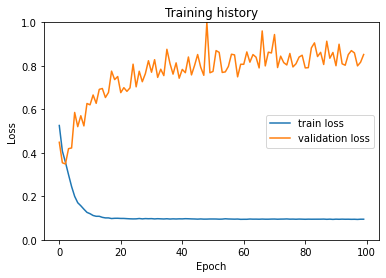

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

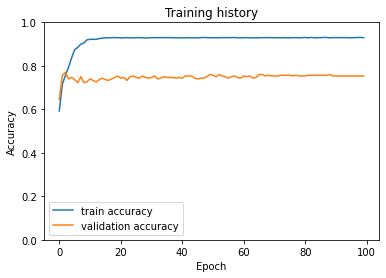

In [ ]:
plt.plot(history['train_accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);